MOMENTUM ANALYSIS FOR SQUID INK

LOAD DATA

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
import warnings

# Ignore future warnings from statsmodels
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- 1. Data Loading ---


HISTORICAL_DATA_DIR = 'C:/Users/Admin/Downloads/round-1-island-data-bottle/round-1-island-data-bottle' 
ROUND_1_PRODUCTS = ["KELP", "RAINFOREST_RESIN", "SQUID_INK"]

def load_historical_data_day(directory_path, day):
    """Loads prices and trades for a specific day."""
    day_data = {}
    day_str = str(day)
    prices_pattern = os.path.join(directory_path, f'prices_round_1_day_{day_str}.csv')
    trades_pattern = os.path.join(directory_path, f'trades_round_1_day_{day_str}.csv')

    price_files = glob.glob(prices_pattern)
    trade_files = glob.glob(trades_pattern)

    if price_files:
        try:
            df_prices = pd.read_csv(price_files[0], sep=';')
            df_prices['day'] = day
            day_data['prices'] = df_prices
            print(f"  Loaded prices for day {day} from {os.path.basename(price_files[0])}")
        except Exception as e:
            print(f"  Error loading prices file for day {day} ({os.path.basename(price_files[0])}): {e}")
    else:
        print(f"  Warning: Prices file not found for day {day}")

    if trade_files:
        try:
            df_trades = pd.read_csv(trade_files[0], sep=';')
            df_trades['day'] = day
            day_data['trades'] = df_trades
            print(f"  Loaded trades for day {day} from {os.path.basename(trade_files[0])}")
        except Exception as e:
            print(f"  Error loading trades file for day {day} ({os.path.basename(trade_files[0])}): {e}")
    else:
        print(f"  Warning: Trades file not found for day {day}")

    return day_data

# Load data for all Round 1 days
all_prices = []
all_trades = []
days = [-2, -1, 0]

print(f"Loading data from: {HISTORICAL_DATA_DIR}")
if not os.path.isdir(HISTORICAL_DATA_DIR):
    print(f"Error: Directory not found: {HISTORICAL_DATA_DIR}")
    # You might want to stop execution here or handle this error appropriately
else:
    for day in days:
        day_data = load_historical_data_day(HISTORICAL_DATA_DIR, day)
        if 'prices' in day_data:
            all_prices.append(day_data['prices'])
        if 'trades' in day_data:
            all_trades.append(day_data['trades'])

# Combine dataframes
prices_df = pd.concat(all_prices, ignore_index=True) if all_prices else pd.DataFrame()
trades_df = pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame()

print("\nFinished loading data.")
if not prices_df.empty:
    print(f"Total price rows: {len(prices_df)}")
else:
    print("Price data is empty!")
if not trades_df.empty:
    print(f"Total trade rows: {len(trades_df)}")
else:
    print("Trade data is empty!")

Loading data from: C:/Users/Admin/Downloads/round-1-island-data-bottle/round-1-island-data-bottle
  Loaded prices for day -2 from prices_round_1_day_-2.csv
  Loaded trades for day -2 from trades_round_1_day_-2.csv
  Loaded prices for day -1 from prices_round_1_day_-1.csv
  Loaded trades for day -1 from trades_round_1_day_-1.csv
  Loaded prices for day 0 from prices_round_1_day_0.csv
  Loaded trades for day 0 from trades_round_1_day_0.csv

Finished loading data.
Total price rows: 90000
Total trade rows: 24886


MID PRICE CALCULATION


In [2]:
def calculate_mid_price(row):
    """Calculates mid-price using best bid and ask."""
    best_bid = row.get('bid_price_1')
    best_ask = row.get('ask_price_1')

    if pd.notna(best_bid) and pd.notna(best_ask):
        return (best_bid + best_ask) / 2.0
    elif pd.notna(best_bid):
        return best_bid # Use bid if ask is missing
    elif pd.notna(best_ask):
        return best_ask # Use ask if bid is missing
    else:
        # Attempt to use level 2 or 3 if level 1 is missing
        best_bid_2 = row.get('bid_price_2')
        best_ask_2 = row.get('ask_price_2')
        if pd.notna(best_bid_2) and pd.notna(best_ask_2):
             return (best_bid_2 + best_ask_2) / 2.0
        # Add more fallbacks if needed (e.g., level 3, last trade price)
        return np.nan # Return NaN if no valid price found

if not prices_df.empty:
    prices_df['mid_price'] = prices_df.apply(calculate_mid_price, axis=1)
    # Forward fill missing mid-prices - check if this is appropriate for momentum analysis
    # prices_df['mid_price'] = prices_df['mid_price'].ffill()
    print("\nMid-price calculated.")
    print(prices_df[['product', 'timestamp', 'bid_price_1', 'ask_price_1', 'mid_price']].head())
else:
    print("\nCannot calculate mid-price, prices_df is empty.")


Mid-price calculated.
            product  timestamp  bid_price_1  ask_price_1  mid_price
0  RAINFOREST_RESIN          0         9996        10004    10000.0
1              KELP          0         1998         2002     2000.0
2         SQUID_INK          0         1998         2002     2000.0
3         SQUID_INK        100         1999         2001     2000.0
4  RAINFOREST_RESIN        100        10000        10005    10002.5


FILTER DATA AND CALCULATE RETURNS

In [3]:
PRODUCT_TO_ANALYZE = "SQUID_INK"

if not prices_df.empty:
    product_prices = prices_df[prices_df['product'] == PRODUCT_TO_ANALYZE].copy()
    product_prices = product_prices.sort_values(by=['day', 'timestamp']).reset_index(drop=True)

    if not product_prices.empty:
        # Calculate log returns
        product_prices['log_return'] = np.log(product_prices['mid_price'] / product_prices['mid_price'].shift(1))

        # Handle potential NaNs created by shift and log(0) or log(negative) if mid_price issues exist
        product_prices.dropna(subset=['log_return'], inplace=True)
        product_prices = product_prices[np.isfinite(product_prices['log_return'])] # Remove inf/-inf

        print(f"\nFiltered for {PRODUCT_TO_ANALYZE} and calculated log returns.")
        print(product_prices[['timestamp', 'mid_price', 'log_return']].head())
        print(f"Number of valid returns for {PRODUCT_TO_ANALYZE}: {len(product_prices)}")
    else:
        print(f"\nNo price data found for {PRODUCT_TO_ANALYZE}.")
else:
    print("\nCannot filter data, prices_df is empty.")
    product_prices = pd.DataFrame() # Ensure it's an empty DF




Filtered for SQUID_INK and calculated log returns.
   timestamp  mid_price  log_return
1        100     2000.0     0.00000
2        200     1998.5    -0.00075
3        300     1998.5     0.00000
4        400     1998.0    -0.00025
5        500     1999.5     0.00075
Number of valid returns for SQUID_INK: 29999


SIGNIFICANCE OF MEAN RETURN

In [4]:
if not product_prices.empty and 'log_return' in product_prices.columns and len(product_prices['log_return']) > 1:
    returns = product_prices['log_return']
    t_stat, p_value = stats.ttest_1samp(returns, 0)

    print(f"\n--- Mean Return Significance ({PRODUCT_TO_ANALYZE}) ---")
    print(f"Mean Log Return: {returns.mean():.6f}")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    alpha = 0.05
    if p_value < alpha:
        print(f"The mean log return is statistically significantly different from zero (p < {alpha}).")
    else:
        print(f"The mean log return is NOT statistically significantly different from zero (p >= {alpha}).")
else:
    print(f"\nCould not perform significance test for {PRODUCT_TO_ANALYZE} (not enough data).")




--- Mean Return Significance (SQUID_INK) ---
Mean Log Return: -0.000003
T-statistic: -0.5287
P-value: 0.5970
The mean log return is NOT statistically significantly different from zero (p >= 0.05).


AUTOCORRELATION



--- Autocorrelation Analysis (SQUID_INK) ---


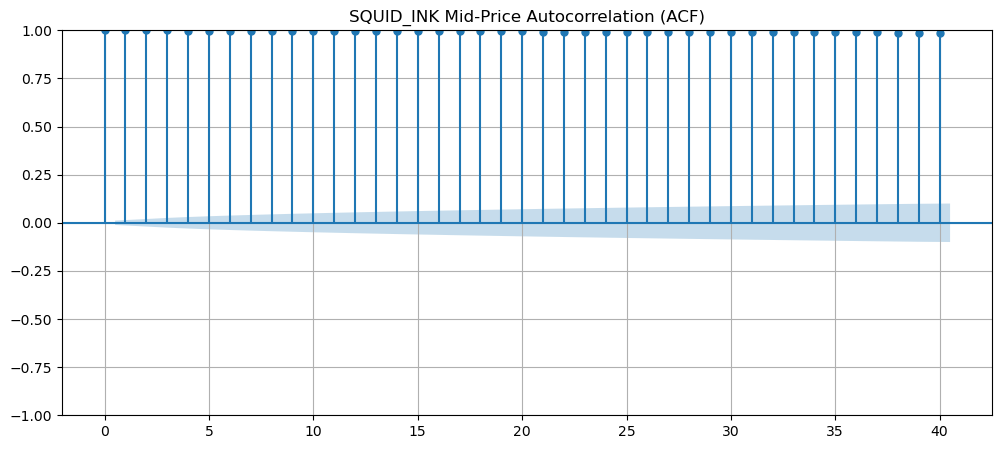

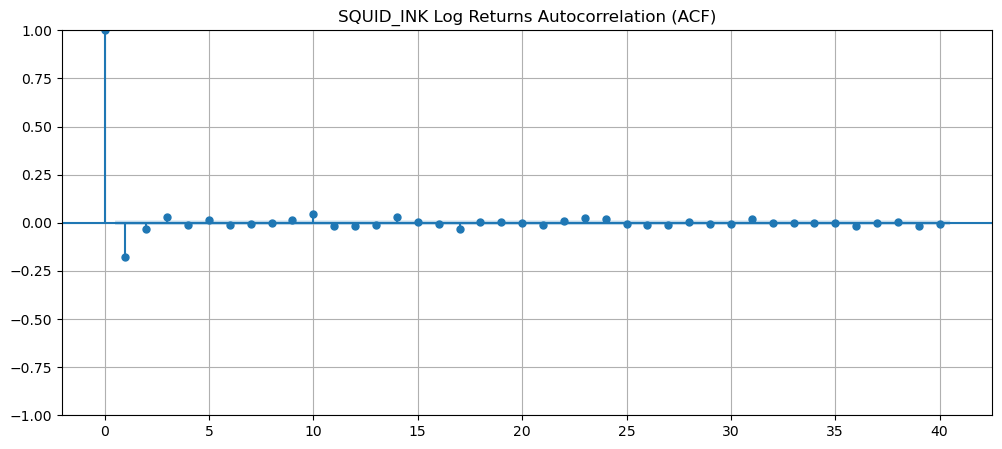

In [5]:
if not product_prices.empty and len(product_prices) > 1:
    print(f"\n--- Autocorrelation Analysis ({PRODUCT_TO_ANALYZE}) ---")

    # ACF for Prices
    fig_price_acf, ax_price_acf = plt.subplots(figsize=(12, 5))
    plot_acf(product_prices['mid_price'].dropna(), ax=ax_price_acf, lags=40, title=f'{PRODUCT_TO_ANALYZE} Mid-Price Autocorrelation (ACF)')
    ax_price_acf.grid(True)
    plt.show()

    # ACF for Log Returns
    if 'log_return' in product_prices.columns and len(product_prices['log_return']) > 1:
        fig_ret_acf, ax_ret_acf = plt.subplots(figsize=(12, 5))
        # Use adjusted lags if fewer returns than default lags
        lags_to_plot = min(40, len(product_prices['log_return']) // 2 - 1)
        if lags_to_plot > 0:
             plot_acf(product_prices['log_return'], ax=ax_ret_acf, lags=lags_to_plot, title=f'{PRODUCT_TO_ANALYZE} Log Returns Autocorrelation (ACF)')
             ax_ret_acf.grid(True)
             plt.show()
        else:
             print("Not enough log return data points to plot ACF.")

    else:
        print("Not enough log return data points to plot ACF.")

else:
    print(f"\nCannot perform autocorrelation analysis for {PRODUCT_TO_ANALYZE} (not enough data).")


if not product_prices.empty:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=product_prices['timestamp'], y=product_prices['mid_price'], mode='lines', name='Mid Price'))
    fig.update_layout(title=f'{PRODUCT_TO_ANALYZE} Mid Price Over Time', xaxis_title='Timestamp', yaxis_title='Price', template='plotly_dark')
    fig.show()

    if 'log_return' in product_prices.columns:
        fig_ret = go.Figure()
        fig_ret.add_trace(go.Scatter(x=product_prices['timestamp'], y=product_prices['log_return'], mode='lines', name='Log Return'))
        fig_ret.update_layout(title=f'{PRODUCT_TO_ANALYZE} Log Returns Over Time', xaxis_title='Timestamp', yaxis_title='Log Return', template='plotly_dark')
        fig_ret.show()
